# Recommender Systems Group Project

In [1]:
data_path ="data_path"

In [2]:
# !mkdir ~/.kaggle #create the .kaggle folder in your root directory
# !echo '{"username":"jdohea","key":"xxxxxxxxxxxxxxxxxxxxxxxx"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json  # set permissions
# !pip install kaggle #install the kaggle library
# !kaggle datasets download -d grouplens/movielens-20m-dataset -p /content/kaggle/
# !unzip kaggle/movielens-20m-dataset.zip -d kaggle
!pip install lenskit

     |████████████████████████████████| 87 kB 2.7 MB/s 
     |████████████████████████████████| 132 kB 14.5 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219320 sha256=cfc5f1925801a681db870babd6fddcc12d2f97bb1d1f65b5e5dcce39e5af2429
  Stored in directory: /root/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5


In [5]:
import pandas as pd
import seaborn as sns
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser
#hello

### Some data exploration

In [6]:
ratings_df = pd.read_csv(data_path+"/ratings.csv", nrows=20000) 
ratings_df.rename(columns={'userId': 'user',
                   'movieId': 'item'},
          inplace=True, errors='raise')
display(ratings_df.head(10))

,user,item,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
5,1,112,3.5,1094785740
6,1,151,4.0,1094785734
7,1,223,4.0,1112485573
8,1,253,4.0,1112484940
9,1,260,4.0,1112484826


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

We get more insight into each of the datasets. We display how many users and movies we have

In [7]:
print(ratings_df.info())
print('number of users: ',len(ratings_df["user"].unique()))
print('number of movies: ', len(ratings_df["item"].unique()))
print()
print('study of ratings')
print(ratings_df.describe()['rating'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user       20000 non-null  int64  
 1   item       20000 non-null  int64  
 2   rating     20000 non-null  float64
 3   timestamp  20000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 625.1 KB
None
number of users:  156
number of movies:  4192

study of ratings
count    20000.000000
mean         3.455500
std          1.121308
min          0.500000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: rating, dtype: float64


Let´s see how often each rating occurs:

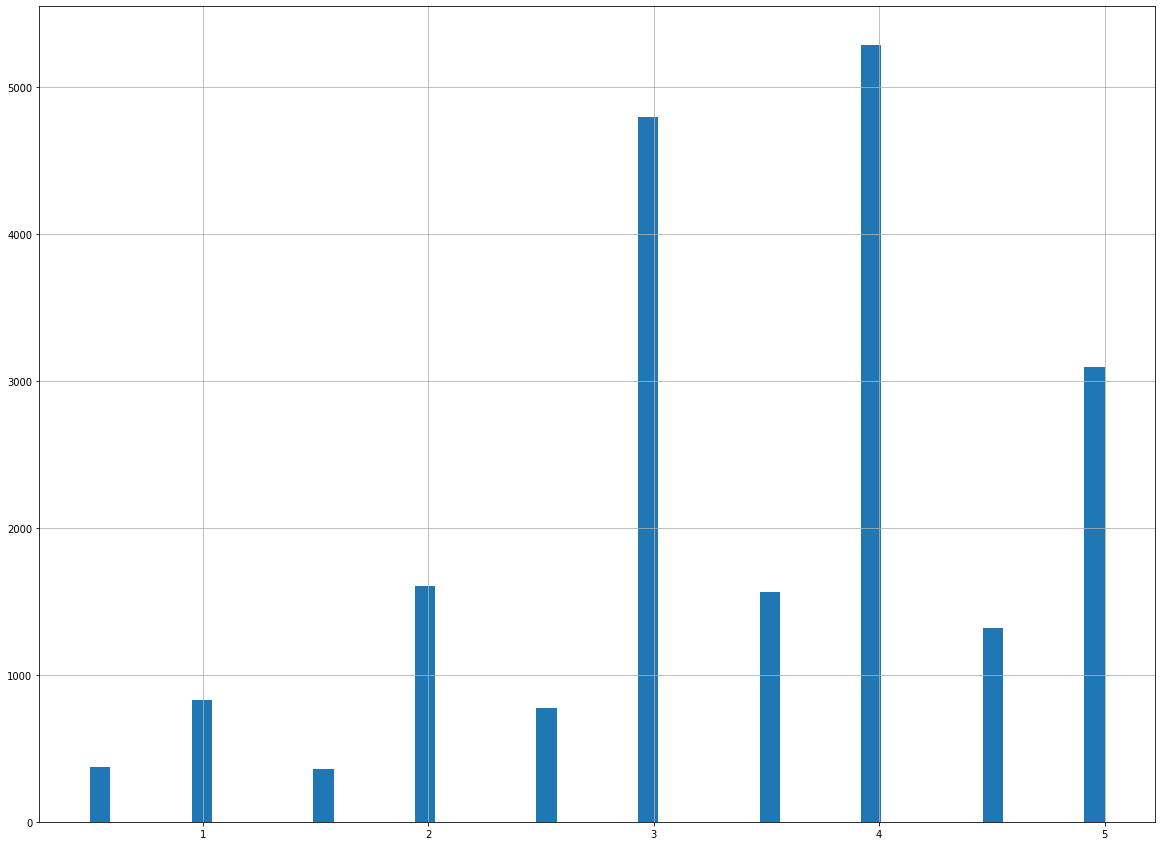

In [8]:
ratings_df['rating'].hist(bins = 50, figsize=(20, 15))

Also display some basic statistical analysis for the movies dataset

In [21]:
movies_df = pd.read_csv(data_path+"/movies.csv")
movies_df.rename(columns={'movieId': 'item'},
          inplace=True, errors='raise')
movies_df.index =movies_df['item']
#movies_df=movies_df[['title', 'genres']]
display(movies_df.head(10))

,item,title,genres
item,,,
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,2,Jumanji (1995),Adventure|Children|Fantasy
3,3,Grumpier Old Men (1995),Comedy|Romance
4,4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,5,Father of the Bride Part II (1995),Comedy
6,6,Heat (1995),Action|Crime|Thriller
7,7,Sabrina (1995),Comedy|Romance
8,8,Tom and Huck (1995),Adventure|Children
9,9,Sudden Death (1995),Action


## Measuring sparsity of datasets

### Visualization of the distribution of the number of evaluations for each movie.
This is pretty muc the code from the lab

,user
item,
1,57
2,21
3,18
4,3
5,11
...,...
116797,1
117511,1
117590,1


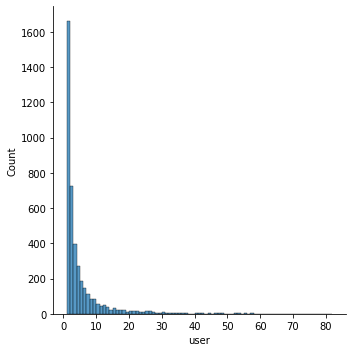

In [10]:

count_ratings_df = ratings_df[['user','item']].groupby(['item']).count()
display(count_ratings_df)
sns.displot(data=count_ratings_df, x='user', binwidth=1)

We want to visuaize instead on the horizontal axe the movies, and on the vertical axe the number of users who evaluated it.

,index,item,user
0,0,296,82
1,1,356,80
2,2,480,73
3,3,318,70
4,4,593,68
...,...,...,...
4187,4187,5958,1
4188,4188,2070,1
4189,4189,2072,1
4190,4190,2084,1


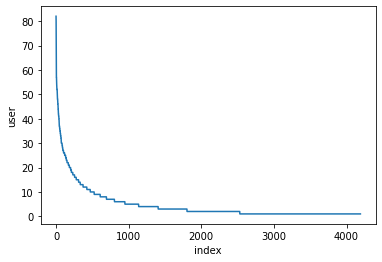

In [11]:
count_ratings_df_ord = count_ratings_df.sort_values(by="user", ascending=False).reset_index().reset_index()
display(count_ratings_df_ord)
sns.lineplot(data=count_ratings_df_ord, x='index', y='user')

# Algorithms:

To make sure our algorithms compile, we need to test the recommendations on a user. To do such thing we select a random user.
For simplicity, we select a random user from the ratings_df Dataframe having more than 100 evaluations.

In [12]:
users_ratings = ratings_df.groupby(['user']).count()

selected = users_ratings['rating'] > 200
selected_users = users_ratings.loc[selected]
random_selected = selected_users.sample()
select_column_df = random_selected.reset_index()['user']
selected_user = select_column_df.iloc[0]

# Collaborative Algorithms

### Collaborative user-user recommender with Lenskit

We use the collaborative user algorithm UserUser, that uses the nearest neighbors algorithm. The constructor takes as inputs the maximum and minumum number of neighbors to consider (we set them to 15 and 3). Then we use the adapt method of the Recommender class, to obtain a Recommender object. Then, we can use the fit method to train the model.

In [14]:
# We use the collaborative user algorithm UserUser, that use the nearest neighbors 
num_recs = 10  # Number of recommendations to generate
user_user = UserUser(15, min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
recsys = Recommender.adapt(user_user)
recsys.fit(ratings_df)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
Numba is using threading layer omp - consider TBB
BLAS using multiple threads - can cause oversubscription
found 2 potential runtime problems - see https://boi.st/lkpy-perf


Now, we can provide the recommendations for a specific user. Let's generate 10 recommendations for the user selected for the previous example. We use the recommend method of the Recommender class to generate the recommendations. Then, we add the title information and display the recommendations.

In [15]:
selected_movies_useruser = recsys.recommend(selected_user, 10) # generate 10 recommendations for the selected user 
selected_movies_useruser = selected_movies_useruser.join(movies_df['title'], on='item')
display(selected_movies_useruser)

,item,score,title
0,66934,5.079266,Dr. Horrible's Sing-Along Blog (2008)
1,2301,4.847650,History of the World: Part I (1981)
2,73,4.796207,"Misérables, Les (1995)"
3,3275,4.773100,"Boondock Saints, The (2000)"
4,1680,4.706072,Sliding Doors (1998)
5,1805,4.690542,Wild Things (1998)
6,6323,4.684650,Identity (2003)
7,1663,4.671536,Stripes (1981)
8,3020,4.567859,Falling Down (1993)
9,162,4.543364,Crumb (1994)


# Content based algorithm


Now, we need to select the user evaluations, that we will use to train our recommender. We print the number of ratings that we have for the considered user, and the extracted dataset, ordered by ratings.

In [19]:
movies_df.head()

,title,genres
item,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [22]:
selected_user_ratings = ratings_df.loc[ratings_df['user'] == selected_user]
selected_user_ratings = selected_user_ratings.sort_values(by='item', ascending=True)
print("Rated movies: " + str(selected_user_ratings.shape[0]))
display(selected_user_ratings.head(10))
rated_movies_df = movies_df.loc[list(selected_user_ratings['item'])]
#rated_movies_df = rated_movies_df[['title', 'plot']]
print("Rated movies: " + str(rated_movies_df.shape[0]))
display(rated_movies_df.head(10))






Rated movies: 246


,user,item,rating,timestamp
3534,31,1,3.0,1424733487
3535,31,110,5.0,1424733473
3536,31,260,5.0,1424733433
3537,31,364,3.0,1424844807
3538,31,527,0.5,1424733598
3539,31,588,3.0,1424842869
3540,31,594,2.5,1424844811
3541,31,616,4.0,1424844817
3542,31,1196,5.0,1424733435
3543,31,1197,3.0,1424734492


Rated movies: 246


,item,title,genres
item,,,
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
110,110,Braveheart (1995),Action|Drama|War
260,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
364,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
527,527,Schindler's List (1993),Drama|War
588,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
594,594,Snow White and the Seven Dwarfs (1937),Animation|Children|Drama|Fantasy|Musical
616,616,"Aristocats, The (1970)",Animation|Children
1196,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi


We use a similar approach to select the unrated movies. We compute the set of movies index that are not rated using the set subtraction operator. We access the index of the movies_df and the rated_movies_df Dataframes, create two sets containing such indexes, compute the difference set diff, and select the movies having an index in the diff set.

In [24]:
diff = set(movies_df.index) - set(rated_movies_df.index)
unrated_movies_df = movies_df.loc[diff]
#unrated_movies_df = unrated_movies_df[['title', 'plot']]
print("Unrated movies: " + str(unrated_movies_df.shape[0]))
display(unrated_movies_df.head(10))

Unrated movies: 27032


,item,title,genres
item,,,
131072,131072,Jesus liebt mich (2012),Comedy
2,2,Jumanji (1995),Adventure|Children|Fantasy
3,3,Grumpier Old Men (1995),Comedy|Romance
4,4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,5,Father of the Bride Part II (1995),Comedy
6,6,Heat (1995),Action|Crime|Thriller
7,7,Sabrina (1995),Comedy|Romance
8,8,Tom and Huck (1995),Adventure|Children
9,9,Sudden Death (1995),Action


Finally, we can add the rating so that we just need to work with a single Dataframe. We do it using the join method. We specify the item as idex in the selected_user_ratings Dataframe to procede with the join. The we select the rating column.

In [28]:
rated_moveies_df = rated_movies_df.drop(['item'], axis = 1, inplace = True) 


KeyError: ignored

In [29]:
rated_movies_df.head()

,title,genres
item,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
110,Braveheart (1995),Action|Drama|War
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
527,Schindler's List (1993),Drama|War


In [30]:

rated_movies_df = rated_movies_df.join(selected_user_ratings.set_index('item')['rating'], on='item')
print("Rated movies: " + str(rated_movies_df.shape[0]))
display(rated_movies_df.head(10))

Rated movies: 246


,title,genres,rating
item,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0
110,Braveheart (1995),Action|Drama|War,5.0
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,5.0
364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,3.0
527,Schindler's List (1993),Drama|War,0.5
588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,3.0
594,Snow White and the Seven Dwarfs (1937),Animation|Children|Drama|Fantasy|Musical,2.5
616,"Aristocats, The (1970)",Animation|Children,4.0
1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,5.0


### Using words frequencies in plots like in the lab
Possible improvements: lemmatization, removal of stopwords, etc, take a look at the library nltk

We have no info on plots, we might have to do something about this! let´s try to get data on plots, else we can not use this method

Compute a feature representation for the movie's contents (TF-IDF)

In [31]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(rated_movies_df['plot'])
print(X.shape)

NameError: ignored

Train a regressor, computing of the predicted ratings for unrated movies, and recommending the movies with higher predicted ratings

In [32]:
X_unrated = vectorizer.transform(unrated_movies_df['plot'])
print(X_unrated.shape)
y_unrated = neigh.predict(X_unrated)
print(y_unrated.shape)

NameError: ignored

### Can we use tags ? (this was not in the lab)

Besides the plots, we have tags for each movie out there. 
We need to inspect whether we have enough data to make a recommendation algorithm using it. 
We need to explore how sparse this data is, how many tags there are for each movie.

In [33]:
tags_df = pd.read_csv(data_path+"/tags.csv", nrows=20000)
tags_df.rename(columns={'userId': 'user',
                   'movieId': 'item'},
          inplace=True, errors='raise')

In [35]:
tags_df.head()

,user,item,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


Let´s see how many tags are in our dataset

In [36]:
print(len(tags_df['tag'].unique()))

5822


Ok, so we know some tags have been assigned to more than one movie, let´s compute the sparsity of the tag feature.
We compute how many times a tag has been assigned to any item.
We again see that we have a long tail-shor tail structure

In [82]:
tags_df['item']= tags_df.index
count_items_per_tag_df = tags_df[['tag','item']].groupby(['tag']).count()
print('Mean:', count_items_per_tag_df.mean())
print('Variance: ', count_items_per_tag_df.var())
count_items_per_tag_df = count_items_per_tag_df.sort_values(by="item", ascending=False).reset_index()
print(count_items_per_tag_df.head())
#print(list(count_tags_df.index))
display(count_items_per_tag_df)
#sns.displot(data=count_items_per_tag_df, x=list(count_items_per_tag_df.index), y='item')

Mean: item    3.454828
dtype: float64
Variance:  item    126.043096
dtype: float64
                 tag  item
0  adapted from:book   510
1             murder   278
2            Watched   160
3            netflix   148
4             sci-fi   145


,tag,item
0,adapted from:book,510
1,murder,278
2,Watched,160
3,netflix,148
4,sci-fi,145
...,...,...
5784,australian,1
5785,authenticity,1
5786,author hates adaptation,1
5787,author: Edgar Rice Burroughs,1


We inspect how many tags each movie has

In [48]:
tags_df['item']= tags_df.index
count_tags_per_movie_df = tags_df[['tag','item']].groupby(['item']).count()
print('Mean:', count_tags_per_movie_df.mean())
print('Variance: ', count_tags_per_movie_df.var())
count_tags_per_movie_df = count_tags_per_movie_df.sort_values(by="tag", ascending=False).reset_index()
print(count_tags_per_movie_df.head())
#print(list(count_tags_df.index))
display(count_tags_per_movie_df)
#sns.displot(data=count_tags_df, x=list(count_tags_per_movie_df.index), y='tag')

Mean: tag    1.0
dtype: float64
Variance:  tag    0.0
dtype: float64
    item  tag
0      0    1
1  13330    1
2  13337    1
3  13336    1
4  13335    1


,item,tag
0,0,1
1,13330,1
2,13337,1
3,13336,1
4,13335,1
...,...,...
19995,6666,1
19996,6665,1
19997,6664,1
19998,6663,1


So there is only one tag per movie! That is worth mentioning for sure!

### Tags preproccessing
We will do two things before running our algorithm#

1.   Grouping tags that have a very similar meaning
2.   Removing tags that are in only one movie



In [66]:
#tags_desc= pd.read_csv(data_path+'/genome-tags.csv')
#tags_desc.rename(columns={'tag': 'tag_txt', 'tagId': 'tag'},
#          inplace=True, errors='raise')
#print(tags_desc.head())
#tags_df = tags_df.join(tags_desc, on='tag')
import numpy as np
print(tags_df.head())
lengths = np.mean(  [len(tag.split(' ')) for tag in list(tags_df['tag'].unique()) ])
print('avg number of words per tag: ', lengths)
tags_df.head()

   user  item            tag   timestamp
0    18     0    Mark Waters  1240597180
1    65     1      dark hero  1368150078
2    65     2      dark hero  1368150079
3    65     3  noir thriller  1368149983
4    65     4      dark hero  1368150078
2.2990381312263826


,user,item,tag,timestamp
0,18,0,Mark Waters,1240597180
1,65,1,dark hero,1368150078
2,65,2,dark hero,1368150079
3,65,3,noir thriller,1368149983
4,65,4,dark hero,1368150078


Load word embeddings to compute similarity betwen tags

Let´s apply lemmatization to all our tags

In [75]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
lemmatized_tags= [lemmatizer.lemmatize(tag) for tag in list(tags_df['tag'].unique()) ]
print('nr tags before lemmatizing: ', len(list(tags_df['tag'].unique())))
print('nr tags after lemmatizing: ', len(set(lemmatized_tags)))

#Lemmatizing reduces redundancy in our data so let´s indeed use it!
tags_df['tag']= tags_df['tag'].apply(lambda  x: lemmatizer.lemmatize(x))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
nr tags before lemmatizing:  5822
nr tags after lemmatizing:  5789


The next thing we need to do is to get all movies which have a tag that has only been used for that particular movie. The movies that have a tag which is only used for them will be excluded of our RS. This is surely a drawback of this approach as we are missing data in many positions.(Possible improvement in the future is this)

In [91]:
count_items_per_tag_df = tags_df[['tag','item']].groupby(['tag']).count() #we need to do it again as the df has changed after lemmatization
tags_relevant = count_items_per_tag_df[count_items_per_tag_df['item']>1]
movies_relevant = tags_df[tags_df['tag'].isin( list(tags_relevant.index))]['item']
#print(movies_relevant.head())
print(movies_relevant.shape)
print(tags_df.shape)
#


(16492,)
(20000, 4)


Now we will build our recommendation algorithm

# Aggregation algorithms for groups of users

Summary:

**Selection of a group in our dataset**
We will select different groups.
 

1.   A random group of 2 users
2.   A random group of 5 users

Then for our algorithms we will assume the group of 2 people represents a couple that have been together for a long time.

We will also assume that the group of 5 people represents 

*   A group of friends
*   A weak relationship group
*   A family with 2 parents and 3 kids

If we had data on demographics we could train our models in such situations, since we do not.

We will try differnet aggregations strategies depending on what our groups represent

The groups will be selected randomly.




**Aggregation Strategies for Group Recommenders:**

The aggregations strategies will be different for each of the groups. We will follow the work of 'Gartrell 2010', he proposes to use different aggregation strategies for different groups in terms of internal strength.


1.   Close relationship-> most pleasure
2.   weak relationships groups-> Least Misery
3.   average group of friends -> average (consensus based) 
4.   Family-> weighted average (prioritizes children opinion while it gives lower weights to adults)



We will study how each different approach behaves for each type of aggregation. 
Then we will motivate why each slgorithm should be better in each case

**Explanations for Group Recommenders **
We will also provide explanations for our recommendations.

It is worth mentioning that instead of the average aggregation strategy, multiplicative aggregation strategy could have been chosen. However it was not chosen due to the fact that users like short and simple explanations. The user would more easily understand the average strategy than the multiplicative strategy. Helping users understand our choice will build their trust in the system, which is something we would like to achieve


### Selecting users: Random group
For simplicity we limit ourselves to selecting users that have more than 200 movies rated.

As explained above we will select a group of two users that represents a couple on a relationship

In [ ]:
users_ratings = ratings_df.groupby(['user']).count()
selected = users_ratings['rating'] > 200
selected_users = users_ratings.loc[selected]
random_selected = selected_users.sample(n=2) # sample() returns now n random rows from the dataframe. The returned object is a dataframe with five rows. 
select_column_df = random_selected.reset_index()['user'] # reset_index() create a new index, and the userId became a column. Then, we can filter using the column name
group_2_users = list(select_column_df) # iloc select by index, since our dataframe only has one row we read it from the index 0
print(group_users)

Now we also select a random group of 5 users that could represent both a group of friends or a weak relationship group

In [ ]:
random_selected = selected_users.sample(n=5) # sample() returns now n random rows from the dataframe. The returned object is a dataframe with five rows. 
select_column_df = random_selected.reset_index()['user'] # reset_index() create a new index, and the userId became a column. Then, we can filter using the column name
group_5_users = list(select_column_df) # iloc select by index, since our dataframe only has one row we read it from the index 0
print(group_5_users)

Let us assume we want to recommend to both groups a list of 10 movies that nobody in the group has seen yet. We first need to determine the list of possible candidates. For simplicity, we will only consider movies for which we more then 10 evaluations


In [ ]:
group_ratings = ratings_df.loc[ratings_df['user'].isin(group_2_users)]
all_movies = set(movies_df.index.tolist())
num_ratings_df = ratings_df.groupby(['item']).count()
considered_movies = set(num_ratings_df.loc[num_ratings_df['user'] > 10].reset_index()['item'])

group_seen_movies = set(group_ratings['item'].tolist())
group_unseen_movies = considered_movies - group_seen_movies

print(len(all_movies))
print(len(considered_movies))
print(len(group_seen_movies))
print(len(group_unseen_movies))

Now, we need to evaluate individuals' preverences for the unseen movies. To do so, we use the Lenskit library. We will use  CF recommender used in the previous example, (user collaborative filter).  To generate the Dataframe with user-item pairs to pass as input in the predict function, we use the product method of the itertools library, which takes as imput two lists and returns all the possible combinations between elements of the two lists. This is passed as input for the Dataframe constructor, which will then generate a Dataframe containing a pair on each row.

In [ ]:
user_user = UserUser(15, min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
recsys = Recommender.adapt(user_user)
recsys.fit(ratings_df)
group_unseen_df = pd.DataFrame(list(itertools.product(group_2_users, group_unseen_movies)), columns=['user', 'item'])
group_unseen_df['predicted_rating'] = recsys.predict(group_unseen_df)
display(group_unseen_df)

### Aggregation Strategies for Group Recommenders

As mentioned before, the aggregation strategies will depend on the group that is using the system.

**For the group of 2 users, which is a couple in love, we will use the least most pleasure aggregation strategy**

**Most pleasure strategy**
The Most Pleasure strategy considers as group rating the maximum of all the individuals ratings. Then, the recommended items are the one scoring the best with such group rating. Again, We can easily implement it grouping our group_unseen_df Dataframe by item, and then computing the max.


In [ ]:
most_pleasure_df = group_unseen_df.groupby('item').max()
most_pleasure_df = most_pleasure_df.join(movies_df['title'], on='item')
most_pleasure_df = most_pleasure_df.sort_values(by="predicted_rating", ascending=False).reset_index()[['item', 'title', 'predicted_rating']]
display(most_pleasure_df.head(10))

**For the group of 5 users, representing a weak relationship type, we will use the least misery strategy.**

**Least Misery strategy**
The Least Misery strategy considers as group rating the minimum of all the individuals ratings. Then, the recommended items are the one scoring the best with such group rating. As we did before, we can implement it grouping our group_unseen_df Dataframe by item, and then computing the min

In [ ]:
# least misery

least_misery_df = group_unseen_df.groupby('item').min()
least_misery_df = least_misery_df.join(movies_df['title'], on='item')
least_misery_df = least_misery_df.sort_values(by="predicted_rating", ascending=False).reset_index()[['item', 'title', 'predicted_rating']]
display(least_misery_df.head(10))

**For the group of 5 users, representing a group of friends, we will use the average strategy.**

**Average strategy**
The Average strategy rates every item using the average of the ratings of each user for that movie

In [ ]:
avg_df = group_unseen_df.groupby('item').min()
avg_df = least_misery_df.join(movies_df['title'], on='item')
avg_df = least_misery_df.sort_values(by="predicted_rating", ascending=False).reset_index()[['item', 'title', 'predicted_rating']]
display(avg_df.head(10))

**Explanations for Group Recommenders**
 For the Least Misery and Most Pleasure strategies we will use use social-choice based explanations as defined in Barile et al., 2021.
 For the average explanation we will use a generic formulation.

**Least Misery:** "i_k has been recommended to the group since no group members has a real problem with it."

**Most Pleasure:** "i_k has been recommended to the group since it achieves the highest of all individual group members."

**Average:** "i_k has been recommended to the group since it achieves the highest average rating out of all other items".




In [ ]:
explanations = {
    "AVG" : "<item> has been recommended to the group since it achieves the highest total average rating.\n",
    "LMS" : "<item> has been recommended to the group since no group members has a real problem with it.\n",
    "MPL" : "<item> has been recommended to the group since it achieves the highest of all individual group members.\n",
}

# Present explanations for the first item of each strategy
movie_title = least_misery_df['title'].iloc[0]
print("Recommendation: " + movie_title.title())
print(explanations["LMS"].replace("<item>", "The movie \"" + movie_title.title() + "\""))

movie_title = most_pleasure_df['title'].iloc[0]
print("Recommendation: " + movie_title.title())
print(explanations["MPL"].replace("<item>", "The movie \"" + movie_title.title() + "\""))

movie_title = avg_df['title'].iloc[0]
print("Recommendation: " + movie_title.title())
print(explanations["AVG"].replace("<item>", "The movie \"" + movie_title.title() + "\""))



 **EVALUATING GROUP RS**


*   Error metric:
*   Coverage:

